In [276]:
import pandas as pd
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path

# Set the checkpoint directory.
# MODEL_CKPT_DIR = 'model_params_big_test'
MODEL_CKPT_DIR = 'res_balanced_accuracy'
MODEL_CKPT_DIR = 'res_f1'

# Paths to the saved model and scaler.
xgb_model_path = Path(MODEL_CKPT_DIR) / 'xgboost_model.json'
scaler_path = Path(MODEL_CKPT_DIR) / 'std_scaler.bin'

# Load the scaler and the pre-trained XGBoost model.
scaler = joblib.load(scaler_path)
model = xgb.XGBClassifier()
model.load_model(xgb_model_path)

/home/anton/micromamba/envs/competitors-xgb/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [277]:
DATA_FILE = Path(MODEL_CKPT_DIR) / 'data.csv'

# > AVERAGE FILES HERE
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_all_query_pairs.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-5_query_pairs.csv'

# > GOOD FILES HERE
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-5_query-23_nonquery-5539_pairs.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-5_query-23_nonquery-5539_embedded.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-20_query-23_nonquery-5539_embedded.csv'
DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-50_query-23_nonquery-5539_embedded.csv'


df_all = pd.read_csv(DATA_FILE)
# df_all.columns.tolist()

In [278]:
N_SKU = 23

subset_sku = pd.Series(df_all.sku_first.unique()).sample(N_SKU, random_state=42).tolist()
df = df_all[df_all['sku_first'].isin(subset_sku)]

print(f'Total Query SKU: {df.sku_first.nunique()}/{df_all.sku_first.nunique()}')
print(f'Total columns: {len(df.columns)}')
df.columns.tolist()

Total Query SKU: 23/23
Total columns: 35


['balance_first',
 'sales_first',
 'rating_first',
 'final_price_first',
 'comments_first',
 'description_first',
 'name_first',
 'options_first',
 'sku_first',
 'has_video_first',
 'photo_count_first',
 'balance_second',
 'sales_second',
 'rating_second',
 'final_price_second',
 'comments_second',
 'description_second',
 'name_second',
 'options_second',
 'sku_second',
 'has_video_second',
 'photo_count_second',
 'iseq_vendor',
 'iseq_color',
 'iseq_brand',
 'iseq_supp',
 'are_related',
 'image_id_first',
 'image_id_second',
 'url_first',
 'url_second',
 'desc_sim',
 'opt_sim',
 'name_sim',
 'img_sim']

In [279]:
# Separate the true labels from the dataset.
if 'label' in df.columns:
    y_true = df['label']

# Define the columns that were not used as features during training.
columns_to_drop = [
    'sku_first', 'sku_second',
    'name_first', 'description_first',
    'name_second', 'description_second',
    'options_first', 'options_second',
    'image_url_first', 'image_url_second',
    'image_id_first', 'image_id_second',
    'label'
]

# Create a DataFrame for scaling by dropping the extra columns.
# The original df remains unchanged.
X = df.drop(columns=columns_to_drop, errors='ignore')

# Ensure the columns match exactly what the scaler was trained on.
# The scaler's attribute 'feature_names_in_' holds the expected column names.
if hasattr(scaler, 'feature_names_in_'):
    expected_features = list(scaler.feature_names_in_)
    X_for_scaler = df[expected_features]
else:
    X_for_scaler = df

# print("Columns used for scaling:", X_for_scaler.columns.tolist())

# Scale the features using the loaded scaler.
X_scaled = scaler.transform(X_for_scaler)
X.columns.tolist()

['balance_first',
 'sales_first',
 'rating_first',
 'final_price_first',
 'comments_first',
 'has_video_first',
 'photo_count_first',
 'balance_second',
 'sales_second',
 'rating_second',
 'final_price_second',
 'comments_second',
 'has_video_second',
 'photo_count_second',
 'iseq_vendor',
 'iseq_color',
 'iseq_brand',
 'iseq_supp',
 'are_related',
 'url_first',
 'url_second',
 'desc_sim',
 'opt_sim',
 'name_sim',
 'img_sim']

In [280]:
import pandas as pd

# Compute predictions and probabilities (using your pre-trained model)
predictions = model.predict(X_scaled)
predicted_probas = model.predict_proba(X_scaled)

# For binary classification, use the positive class probability;
# for multiclass, use the highest probability of any class.
if predicted_probas.shape[1] == 2:
    sort_probas = predicted_probas[:, 1]
else:
    sort_probas = predicted_probas.max(axis=1)

# Create a DataFrame with the predictions and probabilities.
# We align by the original dataframe's index.
results_df = pd.DataFrame({
    'prediction': predictions,
    'proba': sort_probas
}, index=df.index)

# Concatenate the predictions to the original DataFrame.
df_with_preds = pd.concat([df, results_df], axis=1)

# Instead of using groupby.apply (with include_groups), sort directly:
df_grouped_sorted = df_with_preds.sort_values(
    by=['sku_first', 'proba'], ascending=[True, False]
)

print("Data grouped by sku_first and sorted within each group by probability:")
df_grouped_sorted.columns.tolist()

matches_df = df_grouped_sorted.copy()
matches_df = matches_df[matches_df.prediction == 1]

matches_df_short = matches_df[[
    'sku_first', 'sku_second', 'prediction', 'proba',
    'url_first', 'url_second'
]]
matches_df_short.head()

Data grouped by sku_first and sorted within each group by probability:


,sku_first,sku_second,prediction,proba,url_first,url_second
325,491268805,536712621,1,0.990205,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/536712621/
326,491268805,1706808356,1,0.990205,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/1706808356/
327,491268805,679322083,1,0.990205,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/679322083/
348,491268805,1137981392,1,0.963501,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/1137981392/
313,491268805,536711137,1,0.959629,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/536711137/


In [ ]:
TOP_K = 5

for query_idx, (query_sku, query_df) in enumerate(matches_df_short.groupby('sku_first')):
    print(f'Query #{query_idx+1} '+'#' * 40)
    print(f"Query SKU: {query_sku}")
    print(f'Query URL: {query_df['url_first'].iloc[0]}')
    print('-' * 60)
    for top_k_idx, row in query_df.reset_index(drop=True).iterrows():
        if top_k_idx == TOP_K-1:
            break
        print(f"Top-{top_k_idx+1} SKU: {row['sku_second']}")
        print(f'Top-{top_k_idx+1} URL: {row['url_second']}\n')
        
    print()

# TODO: исключить карты, которые не в наличии?

Query #1 ########################################
Query SKU: 491268805
Query URL: https://www.ozon.ru/context/detail/id/491268805/
------------------------------------------------------------
Top-1 SKU: 536712621
Top-1 URL: https://www.ozon.ru/context/detail/id/536712621/

Top-2 SKU: 1706808356
Top-2 URL: https://www.ozon.ru/context/detail/id/1706808356/

Top-3 SKU: 679322083
Top-3 URL: https://www.ozon.ru/context/detail/id/679322083/

Top-4 SKU: 1137981392
Top-4 URL: https://www.ozon.ru/context/detail/id/1137981392/


Query #2 ########################################
Query SKU: 491270272
Query URL: https://www.ozon.ru/context/detail/id/491270272/
------------------------------------------------------------
Top-1 SKU: 843876035
Top-1 URL: https://www.ozon.ru/context/detail/id/843876035/

Top-2 SKU: 601560330
Top-2 URL: https://www.ozon.ru/context/detail/id/601560330/

Top-3 SKU: 1079359016
Top-3 URL: https://www.ozon.ru/context/detail/id/1079359016/


Query #3 #########################

In [282]:
def construct_wide_table(df, top_k):
    """
    Constructs a wide table such that each row corresponds to a unique query SKU and contains:
    
      Query_SKU, Top-1_SKU, Top-2_SKU, ... Top-k_SKU,
      Query_URL, Top-1_URL, Top-2_URL, ... Top-k_URL,
      Top-1_Proba, Top-2_Proba, ... Top-k_Proba
      
    Only candidates with a positive prediction (prediction == 1) are included.
    If there are fewer than top_k positive predictions for a query, the remaining columns are filled with None.
    """
    wide_rows = []
    # Process each unique query SKU.
    for query_sku, group in df.groupby('sku_first'):
        # Consider only candidates with positive prediction.
        group_positive = group[group['prediction'] == 1]
        # Sort the positive candidates by probability in descending order.
        group_sorted = group_positive.sort_values(by='proba', ascending=False).reset_index(drop=True)
        # Assume the query URL is the same for every row with the same query SKU.
        query_url = group_sorted.loc[0, 'url_first'] if not group_sorted.empty else None
        
        # Build the row dictionary with the desired column order.
        row = {}
        row['Query_SKU'] = query_sku
        
        # Add candidate SKU columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_SKU'] = group_sorted.loc[i, 'sku_second']
            else:
                row[f'Top-{i+1}_SKU'] = None
        
        # Add the Query URL.
        row['Query_URL'] = query_url
        
        # Add candidate URL columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_URL'] = group_sorted.loc[i, 'url_second']
            else:
                row[f'Top-{i+1}_URL'] = None
        
        # Add candidate probability columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_proba'] = group_sorted.loc[i, 'proba']
            else:
                row[f'Top-{i+1}_proba'] = None
        
        wide_rows.append(row)
    return pd.DataFrame(wide_rows)


In [288]:
# --- Set your desired top_k (e.g. 5) and construct the wide table.
TOP_K = 5

matches_wide_df = construct_wide_table(df_grouped_sorted, TOP_K)
matches_wide_df = matches_wide_df.dropna()
matches_wide_df

,Query_SKU,Top-1_SKU,Top-2_SKU,Top-3_SKU,Top-4_SKU,Top-5_SKU,Query_URL,Top-1_URL,Top-2_URL,Top-3_URL,Top-4_URL,Top-5_URL,Top-1_proba,Top-2_proba,Top-3_proba,Top-4_proba,Top-5_proba
0,491268805,5.367126e+08,1.706808e+09,6.793221e+08,1.137981e+09,5.367111e+08,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/536712621/,https://www.ozon.ru/context/detail/id/1706808356/,https://www.ozon.ru/context/detail/id/679322083/,https://www.ozon.ru/context/detail/id/1137981392/,https://www.ozon.ru/context/detail/id/536711137/,0.990205,0.990205,0.990205,0.963501,0.959629
2,491270369,6.015557e+08,1.919282e+09,1.919437e+09,1.936548e+09,6.007788e+08,https://www.ozon.ru/context/detail/id/491270369/,https://www.ozon.ru/context/detail/id/601555675/,https://www.ozon.ru/context/detail/id/1919282160/,https://www.ozon.ru/context/detail/id/1919437475/,https://www.ozon.ru/context/detail/id/1936547864/,https://www.ozon.ru/context/detail/id/600778837/,0.995082,0.990581,0.990581,0.987469,0.987469
4,491271320,6.015557e+08,1.314313e+09,1.442552e+09,1.454661e+09,5.530133e+08,https://www.ozon.ru/context/detail/id/491271320/,https://www.ozon.ru/context/detail/id/601555675/,https://www.ozon.ru/context/detail/id/1314312894/,https://www.ozon.ru/context/detail/id/1442552488/,https://www.ozon.ru/context/detail/id/1454661184/,https://www.ozon.ru/context/detail/id/553013273/,0.997647,0.996882,0.996882,0.996882,0.996882
5,491271339,5.367126e+08,6.793221e+08,1.706808e+09,1.710868e+09,1.137981e+09,https://www.ozon.ru/context/detail/id/491271339/,https://www.ozon.ru/context/detail/id/536712621/,https://www.ozon.ru/context/detail/id/679322083/,https://www.ozon.ru/context/detail/id/1706808356/,https://www.ozon.ru/context/detail/id/1710867998/,https://www.ozon.ru/context/detail/id/1137981392/,0.973775,0.973775,0.973775,0.972199,0.950011
6,491271768,1.710868e+09,6.793221e+08,1.706808e+09,5.367126e+08,1.176720e+09,https://www.ozon.ru/context/detail/id/491271768/,https://www.ozon.ru/context/detail/id/1710867998/,https://www.ozon.ru/context/detail/id/679322083/,https://www.ozon.ru/context/detail/id/1706808356/,https://www.ozon.ru/context/detail/id/536712621/,https://www.ozon.ru/context/detail/id/1176719536/,0.955613,0.946227,0.946227,0.946227,0.828888
7,491273438,1.436529e+09,1.436530e+09,1.912008e+09,6.015557e+08,1.283826e+09,https://www.ozon.ru/context/detail/id/491273438/,https://www.ozon.ru/context/detail/id/1436528883/,https://www.ozon.ru/context/detail/id/1436530193/,https://www.ozon.ru/context/detail/id/1912007512/,https://www.ozon.ru/context/detail/id/601555675/,https://www.ozon.ru/context/detail/id/1283826235/,0.999861,0.999861,0.999754,0.999658,0.999411
8,491273791,8.358212e+08,1.919437e+09,1.919282e+09,1.747641e+09,1.130824e+09,https://www.ozon.ru/context/detail/id/491273791/,https://www.ozon.ru/context/detail/id/835821242/,https://www.ozon.ru/context/detail/id/1919437475/,https://www.ozon.ru/context/detail/id/1919282160/,https://www.ozon.ru/context/detail/id/1747641187/,https://www.ozon.ru/context/detail/id/1130823857/,0.952530,0.937472,0.937472,0.865499,0.739156
9,491279127,9.742860e+08,1.595672e+09,1.216411e+09,1.581328e+09,6.469080e+08,https://www.ozon.ru/context/detail/id/491279127/,https://www.ozon.ru/context/detail/id/974286048/,https://www.ozon.ru/context/detail/id/1595672345/,https://www.ozon.ru/context/detail/id/1216410798/,https://www.ozon.ru/context/detail/id/1581328190/,https://www.ozon.ru/context/detail/id/646908035/,0.981543,0.967881,0.967881,0.948153,0.947759
10,492260072,8.546860e+08,1.710806e+09,1.710868e+09,9.512855e+08,1.776963e+09,https://www.ozon.ru/context/detail/id/492260072/,https://www.ozon.ru/context/detail/id/854685999/,https://www.ozon.ru/context/detail/id/1710805919/,https://www.ozon.ru/context/detail/id/1710867998/,https://www.ozon.ru/context/detail/id/951285479/,https://www.ozon.ru/context/detail/id/1776962668/,0.978499,0.948783,0.940249,0.918139,0.910079
12,507113963,1.461311e+09,1.460392e+09,1.46014

In [289]:
DATA_PATH = 'data'

input_file_path = Path(DATA_FILE)
output_file_path = (
    input_file_path.parent /
    Path('test_results') / 
    (f'result-{MODEL_CKPT_DIR}_' + input_file_path.name)
)
output_file_path.parent.mkdir(parents=True, exist_ok=True)
# output_file_path

matches_wide_df.to_csv(output_file_path, index=None)

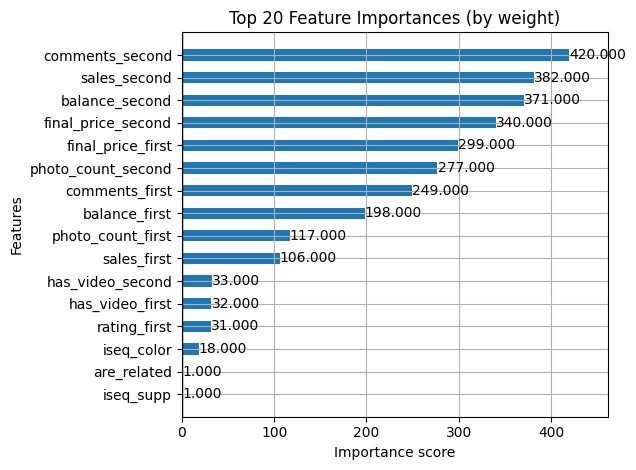

In [290]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assume you already have a scaler and a DataFrame X_for_scaler that were used during training.
# For example, earlier you may have extracted:
# if hasattr(scaler, 'feature_names_in_'):
#     feature_names = list(scaler.feature_names_in_)
# else:
#     feature_names = X_for_scaler.columns.tolist()

if hasattr(scaler, 'feature_names_in_'):
    feature_names = list(scaler.feature_names_in_)
else:
    feature_names = X_for_scaler.columns.tolist()

# Set the original feature names in the booster
booster = model.get_booster()
booster.feature_names = feature_names

# Now plot the feature importance using the booster (which now has the correct names)
ax = xgb.plot_importance(
    booster,
    importance_type='weight',
    max_num_features=20,
    height=0.5,
    show_values=False  # Turn off default text; we'll annotate manually.
)

plt.title("Top 20 Feature Importances (by weight)")
# Optional: Draw a vertical line at x=0 for clarity when some weights are negative.
plt.axvline(x=0, color='black', linewidth=1)

# Label each bar manually so they're formatted nicely.
offset = 0.02  # This offset shifts the label a little to the right.
for patch in ax.patches:
    bar_width = patch.get_width()
    bar_y_center = patch.get_y() + patch.get_height() / 2
    # For positive values, label at the bar's end; for negative, anchor at x=0.
    label_x = bar_width + offset if bar_width >= 0 else 0 + offset
    ax.text(label_x, bar_y_center, f"{bar_width:.3f}", ha='left', va='center')

plt.tight_layout()
plt.show()
